In [1]:
library(raster)
library(sf)
library(terra)
library(dplyr)
library(purrr)

Loading required package: sp


Warning messages:
1: package ‘raster’ was built under R version 4.3.3 
2: package ‘sp’ was built under R version 4.3.3 


Linking to GEOS 3.11.2, GDAL 3.6.2, PROJ 9.2.0; sf_use_s2() is TRUE
terra 1.8.29


Warning message:
package ‘terra’ was built under R version 4.3.3 



Attaching package: ‘dplyr’

The following objects are masked from ‘package:terra’:

    intersect, union

The following objects are masked from ‘package:raster’:

    intersect, select, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Warning message:
package ‘dplyr’ was built under R version 4.3.3 


In [2]:
records_path <- "Data/Records/insects_records_clean.csv"
raster_path  <- "Results/raster/GAM_prediction_alpha.tif"
out_dir      <- "Results/GIE"

dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)

# ------------------------------
# 1) Helpers
# ------------------------------
utm_epsg_from_lonlat <- function(lon, lat) {
  zone <- floor((lon + 180) / 6) + 1
  if (lat >= 0) 32600 + zone else 32700 + zone
}

# Kernel Gaussiano truncado (dist en m)
kernel_gauss_trunc <- function(dist_m, Rc_m, sigma_m) {
  w <- exp(-(dist_m^2) / (2 * sigma_m^2))
  w[dist_m > Rc_m] <- 0
  w
}

# sigma como fracción de Rc (suavidad)
sigma_from_Rc <- function(Rc_m) Rc_m / 3

# ------------------------------
# 2) Cargar datos y raster
# ------------------------------
insects_records <- read.csv(records_path)

# Ajusta nombres si difieren
# Requeridos: taxonRank, scientificName, decimalLongitude, decimalLatitude
stopifnot(all(c("taxonRank","scientificName","decimalLongitude","decimalLatitude") %in% names(insects_records)))

insects_records <- insects_records %>%
  filter(taxonRank == "species") %>%
  filter(!is.na(scientificName),
         !is.na(decimalLongitude),
         !is.na(decimalLatitude))

raster_ref_ll <- rast(raster_path)

# ------------------------------
# 3) Definir CRS métrico (UTM) y reproyectar raster plantilla
# ------------------------------
# Centro del raster en lon/lat (si el raster no tiene lon/lat, usamos su centro igualmente)
ext_ll <- ext(raster_ref_ll)
lon0 <- (ext_ll$xmin + ext_ll$xmax) / 2
lat0 <- (ext_ll$ymin + ext_ll$ymax) / 2

# Si raster está en lon/lat, lon0/lat0 están en grados y esto funciona bien.
# Si no, aún así solo se usa para estimar UTM; en ese caso es mejor definir EPSG manual.
epsg_utm <- utm_epsg_from_lonlat(lon0, lat0)
crs_utm  <- paste0("EPSG:", epsg_utm)

# Reproyectar raster a UTM si está en lon/lat; si no, igual forzamos plantilla en UTM para coherencia
# Define resolución objetivo en metros (ajusta a tu escala)
target_res_m <- 1000

raster_ref_utm <- project(raster_ref_ll, crs_utm, res = target_res_m, method = "bilinear")
writeRaster(raster_ref_utm, file.path(out_dir, "raster_ref_utm.tif"), overwrite = TRUE)

# ------------------------------
# 4) Pasar ocurrencias a UTM (SpatVector)
# ------------------------------
insects_records_sf <- st_as_sf(
  insects_records,
  coords = c("decimalLongitude","decimalLatitude"),
  crs = 4326,
  remove = FALSE
)

pts_v <- vect(insects_records_sf)
pts_v <- project(pts_v, crs(raster_ref_utm))

coords <- crds(pts_v, df = TRUE)
pts_df <- data.frame(
  scientificName = pts_v$scientificName,
  x = coords[,1],
  y = coords[,2],
  stringsAsFactors = FALSE
)

# ------------------------------
# 5) Filtrar especies con mínimo 3 registros
# ------------------------------
min_records <- 5

spp_n <- pts_df %>%
  count(scientificName, name = "n") %>%
  filter(n >= min_records)

pts_df <- pts_df %>% inner_join(spp_n, by = "scientificName")

# ------------------------------
# 6) Centroide y di por especie
# ------------------------------
centroids <- pts_df %>%
  group_by(scientificName) %>%
  summarise(
    n  = dplyr::first(n),
    cx = mean(x),
    cy = mean(y),
    .groups = "drop"
  )

# di_m (máxima distancia al centroide), en metros
pts_split <- split(pts_df, pts_df$scientificName)

di_tbl <- lapply(names(pts_split), function(sp) {
  d  <- pts_split[[sp]]
  cx <- centroids$cx[centroids$scientificName == sp]
  cy <- centroids$cy[centroids$scientificName == sp]
  di_m <- max(sqrt((d$x - cx)^2 + (d$y - cy)^2), na.rm = TRUE)
  data.frame(scientificName = sp, di_m = di_m)
}) |> bind_rows()

centroids <- centroids %>%
  left_join(di_tbl, by = "scientificName") %>%
  mutate(di_km = di_m / 1000)

# ------------------------------
# 7) Categorías de rango (como el paper; ajustable)
# ------------------------------
breaks_km <- c(0, 50, 100, 200, 300, 400, Inf)

centroids <- centroids %>%
  mutate(cat = cut(di_km, breaks = breaks_km, include.lowest = TRUE, right = TRUE))

# Rc por categoría = max(di) de la categoría (m)
rc_by_cat <- centroids %>%
  group_by(cat) %>%
  summarise(Rc_km = max(di_km, na.rm = TRUE), .groups = "drop") %>%
  mutate(Rc_m = Rc_km * 1000)

# Guardar tabla de control
write.csv(
  centroids %>% st_drop_geometry(),
  file.path(out_dir, "centroids_di.csv"),
  row.names = FALSE
)
write.csv(
  rc_by_cat,
  file.path(out_dir, "Rc_by_category.csv"),
  row.names = FALSE
)

# ------------------------------
# 8) Kernel por categoría + consenso
# ------------------------------
r_template <- raster_ref_utm
values(r_template) <- 0

# Centroides a vector
cen_v <- vect(centroids, geom = c("cx","cy"), crs = crs(r_template))

k_by_cat <- list()

cats <- levels(centroids$cat)
cats <- cats[!is.na(cats)]

for (ct in cats) {
  message("Procesando categoría: ", ct)

  # radios por categoría
  Rc_m <- rc_by_cat %>% filter(cat == ct) %>% pull(Rc_m)
  if (length(Rc_m) == 0 || is.na(Rc_m) || Rc_m <= 0) next

  sigma_m <- sigma_from_Rc(Rc_m)

  # centroides de la categoría
  v_ct <- cen_v[cen_v$cat == ct, ]
  if (nrow(v_ct) == 0) next

  k_cat <- rast(r_template)
  values(k_cat) <- 0

  # Suma de kernels por centroide
  for (i in seq_len(nrow(v_ct))) {
    p <- v_ct[i]
    d <- distance(r_template, p)  # metros
    w <- app(d, fun = function(x) kernel_gauss_trunc(x, Rc_m, sigma_m))
    k_cat <- k_cat + w
  }

  nm <- paste0("k_", gsub("[^0-9A-Za-z]+", "_", ct))
  names(k_cat) <- nm
  k_by_cat[[as.character(ct)]] <- k_cat

  writeRaster(k_cat, file.path(out_dir, paste0(nm, ".tif")), overwrite = TRUE)
}

if (length(k_by_cat) == 0) stop("No se generó ningún k por categoría. Revisa filtros y CRS.")

# Consenso: estandariza 0–1 por categoría y suma (paper)
k_std <- lapply(k_by_cat, function(r) {
  mx <- global(r, "max", na.rm = TRUE)[1,1]
  if (is.na(mx) || mx == 0) return(r * 0)
  r / mx
})

k_consensus <- Reduce(`+`, k_std)
names(k_consensus) <- "k_consensus"

Procesando categoría: [0,50]
Procesando categoría: (50,100]
Procesando categoría: (100,200]
Procesando categoría: (200,300]
Procesando categoría: (300,400]
Procesando categoría: (400,Inf]


In [3]:
ecu = st_read("Data/Shp/ecuador_limits.shp")
k_consensus_4326 <- project(k_consensus, "EPSG:4326")
k_consensus_ecu = mask(crop(k_consensus_4326, ecu), ecu)

# Normalización min-max a [0, 1] (ignorando NA)
rmin <- global(k_consensus_ecu, "min", na.rm = TRUE)[1,1]
rmax <- global(k_consensus_ecu, "max", na.rm = TRUE)[1,1]

k_consensus_01 <- (k_consensus_ecu - rmin) / (rmax - rmin)

# (opcional) asegurar límites numéricos por redondeos
k_consensus_01 <- clamp(k_consensus_01, lower = 0, upper = 1, values = TRUE)

Reading layer `ecuador_limits' from data source 
  `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\ecuador_limits.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -81.01115 ymin: -5.016157 xmax: -75.18715 ymax: 1.453982
Geodetic CRS:  WGS 84


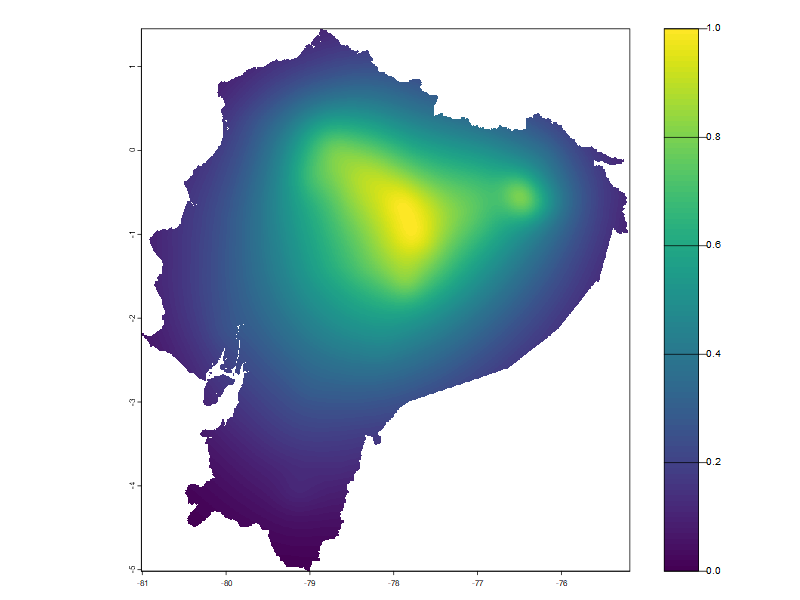

In [4]:
plot(k_consensus_01)

In [5]:
writeRaster(k_consensus_01,  "Results/GIE/Endemism_consensus.tiff", overwrite=TRUE)